In [1]:
from __future__ import division
import os
import time
import math
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.layers import Layer, InputSpec, Conv2D, Conv2DTranspose, Activation, Reshape, LayerNormalization, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import Input, UpSampling2D, Dropout, Concatenate, Add, Dense, Multiply, LeakyReLU, Flatten, AveragePooling2D, Multiply
from tensorflow.keras import initializers, regularizers, constraints, Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
MODEL_NAME = 'PGGAN'
DATA_BASE_DIR = '../../dataset/CelebAMask-HQ/CelebA-HQ-img' # Modify this to your dataset path.
OUTPUT_PATH = 'outputs'
MODEL_PATH = 'models'
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", 'train_data') # Sets up a log directory.
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
batch_size = 16
# Start from 4 * 4
image_size = 4
NOISE_DIM = 512
LAMBDA = 10

EPOCHs = 320
CURRENT_EPOCH = 1 # Epoch start from 1. If resume training, set this to the previous model saving epoch.
total_data_number = len(os.listdir(DATA_BASE_DIR))

# For training speed, this number is lower than the original paper, however the output quality would be lower.
switch_res_every_n_epoch = 40
#switch_res_every_n_epoch = math.ceil(800000 / total_data_number)

SAVE_EVERY_N_EPOCH = 5 # Save checkpoint at every n epoch

LR = 1e-3
BETA_1 = 0.
BETA_2 = 0.99
EPSILON = 1e-8
# Decay learning rate
MIN_LR = 0.000001
DECAY_FACTOR=1.00004

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)
#test_file_writer = tf.summary.create_file_writer(TEST_LOGDIR)

In [3]:
list_ds = tf.data.Dataset.list_files(DATA_BASE_DIR + '/*')

for f in list_ds.take(5):
    print(f.numpy())

b'..\\..\\dataset\\CelebAMask-HQ\\CelebA-HQ-img\\24354.jpg'
b'..\\..\\dataset\\CelebAMask-HQ\\CelebA-HQ-img\\3962.jpg'
b'..\\..\\dataset\\CelebAMask-HQ\\CelebA-HQ-img\\9871.jpg'
b'..\\..\\dataset\\CelebAMask-HQ\\CelebA-HQ-img\\14240.jpg'
b'..\\..\\dataset\\CelebAMask-HQ\\CelebA-HQ-img\\29639.jpg'


In [4]:
def normalize(image):
    '''
        normalizing the images to [-1, 1]
    '''
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

def augmentation(image):
    '''
        Perform some augmentation
    '''
    image = tf.image.random_flip_left_right(image)
    return image

def preprocess_image(file_path, target_size=512):
    images = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    images = tf.image.decode_jpeg(images, channels=3)
    images = tf.image.resize(images, (target_size, target_size),
                           method='nearest', antialias=True)
    images = augmentation(images)
    images = normalize(images)
    return images

In [5]:
preprocess_function = partial(preprocess_image, target_size=image_size)
train_data = list_ds.map(preprocess_function).shuffle(100).batch(batch_size)

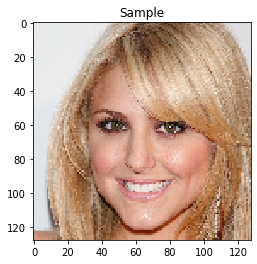

In [6]:
sample_img = next(iter(train_data))
plt.title('Sample')
plt.imshow(np.clip(sample_img[0] * 0.5 + 0.5, 0, 1))

In [7]:
class EqualizeLearningRate(tf.keras.layers.Wrapper):
    """
    Reference from WeightNormalization implementation of TF Addons
    EqualizeLearningRate wrapper works for keras CNN and Dense (RNN not tested).
    ```python
      net = EqualizeLearningRate(
          tf.keras.layers.Conv2D(2, 2, activation='relu'),
          input_shape=(32, 32, 3),
          data_init=True)(x)
      net = EqualizeLearningRate(
          tf.keras.layers.Conv2D(16, 5, activation='relu'),
          data_init=True)(net)
      net = EqualizeLearningRate(
          tf.keras.layers.Dense(120, activation='relu'),
          data_init=True)(net)
      net = EqualizeLearningRate(
          tf.keras.layers.Dense(n_classes),
          data_init=True)(net)
    ```
    Arguments:
      layer: a layer instance.
    Raises:
      ValueError: If `Layer` does not contain a `kernel` of weights
    """

    def __init__(self, layer, **kwargs):
        super(EqualizeLearningRate, self).__init__(layer, **kwargs)
        self._track_trackable(layer, name='layer')
        self.is_rnn = isinstance(self.layer, tf.keras.layers.RNN)

    def build(self, input_shape):
        """Build `Layer`"""
        input_shape = tf.TensorShape(input_shape)
        self.input_spec = tf.keras.layers.InputSpec(
            shape=[None] + input_shape[1:])

        if not self.layer.built:
            self.layer.build(input_shape)

        kernel_layer = self.layer.cell if self.is_rnn else self.layer

        if not hasattr(kernel_layer, 'kernel'):
            raise ValueError('`EqualizeLearningRate` must wrap a layer that'
                             ' contains a `kernel` for weights')

        if self.is_rnn:
            kernel = kernel_layer.recurrent_kernel
        else:
            kernel = kernel_layer.kernel

        # He constant
        self.fan_in, self.fan_out= self._compute_fans(kernel.shape)
        self.he_constant = tf.Variable(1.0 / np.sqrt(self.fan_in), dtype=tf.float32, trainable=False)

        self.v = kernel
        self.built = True
    
    def call(self, inputs, training=True):
        """Call `Layer`"""

        with tf.name_scope('compute_weights'):
            # Multiply the kernel with the he constant.
            kernel = tf.identity(self.v * self.he_constant)
            
            if self.is_rnn:
                print(self.is_rnn)
                self.layer.cell.recurrent_kernel = kernel
                update_kernel = tf.identity(self.layer.cell.recurrent_kernel)
            else:
                self.layer.kernel = kernel
                update_kernel = tf.identity(self.layer.kernel)

            # Ensure we calculate result after updating kernel.
            with tf.control_dependencies([update_kernel]):
                outputs = self.layer(inputs)
                return outputs

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(
            self.layer.compute_output_shape(input_shape).as_list())
    
    def _compute_fans(self, shape, data_format='channels_last'):
        """
        From Official Keras implementation
        Computes the number of input and output units for a weight shape.
        # Arguments
            shape: Integer shape tuple.
            data_format: Image data format to use for convolution kernels.
                Note that all kernels in Keras are standardized on the
                `channels_last` ordering (even when inputs are set
                to `channels_first`).
        # Returns
            A tuple of scalars, `(fan_in, fan_out)`.
        # Raises
            ValueError: in case of invalid `data_format` argument.
        """
        if len(shape) == 2:
            fan_in = shape[0]
            fan_out = shape[1]
        elif len(shape) in {3, 4, 5}:
            # Assuming convolution kernels (1D, 2D or 3D).
            # TH kernel shape: (depth, input_depth, ...)
            # TF kernel shape: (..., input_depth, depth)
            if data_format == 'channels_first':
                receptive_field_size = np.prod(shape[2:])
                fan_in = shape[1] * receptive_field_size
                fan_out = shape[0] * receptive_field_size
            elif data_format == 'channels_last':
                receptive_field_size = np.prod(shape[:-2])
                fan_in = shape[-2] * receptive_field_size
                fan_out = shape[-1] * receptive_field_size
            else:
                raise ValueError('Invalid data_format: ' + data_format)
        else:
            # No specific assumptions.
            fan_in = np.sqrt(np.prod(shape))
            fan_out = np.sqrt(np.prod(shape))
        return fan_in, fan_out

In [8]:
#kernel_initializer = RandomNormal(mean=0.0, stddev=1.0)
kernel_initializer = 'he_normal'

class PixelNormalization(tf.keras.layers.Layer):
    """
    Arguments:
      epsilon: a float-point number, the default is 1e-8
    """
    def __init__(self, epsilon=1e-8):
        super(PixelNormalization, self).__init__()
        self.epsilon = epsilon

    def call(self, inputs):
        return inputs / tf.sqrt(tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True) + self.epsilon)
    
    def compute_output_shape(self, input_shape):
        return input_shape

class MinibatchSTDDEV(tf.keras.layers.Layer):
    """
    Reference from official pggan implementation
    https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py
    
    Arguments:
      group_size: a integer number, minibatch must be divisible by (or smaller than) group_size.
    """
    def __init__(self, group_size=4):
        super(MinibatchSTDDEV, self).__init__()
        self.group_size = group_size

    def call(self, inputs):
        group_size = tf.minimum(self.group_size, tf.shape(inputs)[0])     # Minibatch must be divisible by (or smaller than) group_size.
        s = inputs.shape                                             # [NHWC]  Input shape.
        y = tf.reshape(inputs, [group_size, -1, s[1], s[2], s[3]])   # [GMHWC] Split minibatch into M groups of size G.
        y = tf.cast(y, tf.float32)                              # [GMHWC] Cast to FP32.
        y -= tf.reduce_mean(y, axis=0, keepdims=True)           # [GMHWC] Subtract mean over group.
        y = tf.reduce_mean(tf.square(y), axis=0)                # [MHWC]  Calc variance over group.
        y = tf.sqrt(y + 1e-8)                                   # [MHWC]  Calc stddev over group.
        y = tf.reduce_mean(y, axis=[1,2,3], keepdims=True)      # [M111]  Take average over fmaps and pixels.
        y = tf.cast(y, inputs.dtype)                                 # [M111]  Cast back to original data type.
        y = tf.tile(y, [group_size, s[1], s[2], 1])             # [NHW1]  Replicate over group and pixels.
        return tf.concat([inputs, y], axis=-1)                        # [NHWC]  Append as new fmap.
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], input_shape[3] + 1)


def upsample_block(x, in_filters, filters, kernel_size=3, strides=1, padding='valid', activation=tf.nn.leaky_relu, name=''):
    '''
        Upsampling + 2 Convolution-Activation
    '''
    upsample = UpSampling2D(size=2, interpolation='nearest')(x)
    upsample_x = EqualizeLearningRate(Conv2D(filters, kernel_size, strides, padding=padding,
                   kernel_initializer=kernel_initializer, bias_initializer='zeros'), name=name+'_conv2d_1')(upsample)
    x = PixelNormalization()(upsample_x)
    x = Activation(activation)(x)
    x = EqualizeLearningRate(Conv2D(filters, kernel_size, strides, padding=padding,
                                   kernel_initializer=kernel_initializer, bias_initializer='zeros'), name=name+'_conv2d_2')(x)
    x = PixelNormalization()(x)
    x = Activation(activation)(x)
    return x, upsample

def downsample_block(x, filters1, filters2, kernel_size=3, strides=1, padding='valid', activation=tf.nn.leaky_relu, name=''):
    '''
        2 Convolution-Activation + Downsampling
    '''
    x = EqualizeLearningRate(Conv2D(filters1, kernel_size, strides, padding=padding,
               kernel_initializer=kernel_initializer, bias_initializer='zeros'), name=name+'_conv2d_1')(x)
    x = Activation(activation)(x)
    x = EqualizeLearningRate(Conv2D(filters2, kernel_size, strides, padding=padding,
               kernel_initializer=kernel_initializer, bias_initializer='zeros'), name=name+'_conv2d_2')(x)
    x = Activation(activation)(x)
    downsample = AveragePooling2D(pool_size=2)(x)

    return downsample

## I used tanh in the G output layers, I didn't test not using activation(linear in the paper) in the output layer, maybe using linear is better.

In [9]:
# output_activation = tf.keras.activations.linear
output_activation = tf.keras.activations.tanh

def generator_input_block(x):
    '''
        Generator input block
    '''
    x = EqualizeLearningRate(Dense(4*4*512, kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='g_input_dense')(x)
    x = PixelNormalization()(x)
    x = LeakyReLU()(x)
    x = Reshape((4, 4, 512))(x)
    x = EqualizeLearningRate(Conv2D(512, 3, strides=1, padding='same',
                                          kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='g_input_conv2d')(x)
    x = PixelNormalization()(x)
    x = LeakyReLU()(x)
    return x

def build_4x4_generator(noise_dim=NOISE_DIM):
    '''
        4 * 4 Generator
    '''
    # Initial block
    inputs = Input(noise_dim)
    x = generator_input_block(inputs)
    # Not used in 4 * 4, put it here in order to keep the input here same as the other models
    alpha = Input((1), name='input_alpha')
    to_rgb = EqualizeLearningRate(Conv2D(3, kernel_size=1, strides=1,  padding='same', activation=output_activation,
                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='to_rgb_{}x{}'.format(4, 4))
    
    rgb_out = to_rgb(x)
    model = Model(inputs=[inputs, alpha], outputs=rgb_out)
    return model

def build_8x8_generator(noise_dim=NOISE_DIM):
    '''
        8 * 8 Generator
    '''
    # Initial block
    inputs = Input(noise_dim)
    x = generator_input_block(inputs)
    alpha = Input((1), name='input_alpha')
    
    ########################
    # Fade in block
    ########################
    x, up_x = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(8, 8))
    
    
    previous_to_rgb = EqualizeLearningRate(Conv2D(3, kernel_size=1, strides=1,  padding='same', activation=output_activation,
                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='to_rgb_{}x{}'.format(4, 4))
    to_rgb = EqualizeLearningRate(Conv2D(3, kernel_size=1, strides=1,  padding='same', activation=output_activation,
                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='to_rgb_{}x{}'.format(8, 8))

    l_x = to_rgb(x)
    r_x = previous_to_rgb(up_x)
    ########################
    # Left branch in the paper
    ########################
    l_x = Multiply()([1 - alpha, l_x])
    ########################
    # Right branch in the paper
    ########################
    r_x = Multiply()([alpha, r_x])
    combined = Add()([l_x, r_x])
    
    model = Model(inputs=[inputs, alpha], outputs=combined)
    return model

def build_16x16_generator(noise_dim=NOISE_DIM):
    '''
        16 * 16 Generator
    '''
    # Initial block
    inputs = Input(noise_dim)
    x = generator_input_block(inputs)
    alpha = Input((1), name='input_alpha')
    ########################
    # Stable blocks
    ########################
    x, _ = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(8, 8))
    ########################
    # Fade in block
    ########################
    x, up_x = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(16, 16))
    
    previous_to_rgb = EqualizeLearningRate(Conv2D(3, kernel_size=1, strides=1,  padding='same', activation=output_activation,
                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='to_rgb_{}x{}'.format(8, 8))
    to_rgb = EqualizeLearningRate(Conv2D(3, kernel_size=1, strides=1,  padding='same', activation=output_activation,
                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='to_rgb_{}x{}'.format(16, 16))

    l_x = to_rgb(x)
    r_x = previous_to_rgb(up_x)
    ########################
    # Left branch in the paper
    ########################
    l_x = Multiply()([1 - alpha, l_x])
    ########################
    # Right branch in the paper
    ########################
    r_x = Multiply()([alpha, r_x])
    combined = Add()([l_x, r_x])
    
    model = Model(inputs=[inputs, alpha], outputs=combined)
    return model

def build_32x32_generator(noise_dim=NOISE_DIM):
    '''
        32 * 32 Generator
    '''
    # Initial block
    inputs = Input(noise_dim)
    x = generator_input_block(inputs)
    alpha = Input((1), name='input_alpha')
    ########################
    # Stable blocks
    ########################
    x, _ = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(8, 8))
    x, _ = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(16, 16))
    ########################
    # Fade in block
    ########################
    x, up_x = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(32, 32))
    
    previous_to_rgb = EqualizeLearningRate(Conv2D(3, kernel_size=1, strides=1,  padding='same', activation=output_activation,
                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='to_rgb_{}x{}'.format(16, 16))
    to_rgb = EqualizeLearningRate(Conv2D(3, kernel_size=1, strides=1,  padding='same', activation=output_activation,
                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='to_rgb_{}x{}'.format(32, 32))

    l_x = to_rgb(x)
    r_x = previous_to_rgb(up_x)
    ########################
    # Left branch in the paper
    ########################
    l_x = Multiply()([1 - alpha, l_x])
    ########################
    # Right branch in the paper
    ########################
    r_x = Multiply()([alpha, r_x])
    combined = Add()([l_x, r_x])
    
    model = Model(inputs=[inputs, alpha], outputs=combined)
    return model

def build_64x64_generator(noise_dim=NOISE_DIM):
    '''
        64 * 64 Generator
    '''
    # Initial block
    inputs = Input(noise_dim)
    x = generator_input_block(inputs)
    alpha = Input((1), name='input_alpha')
    ########################
    # Stable blocks
    ########################
    x, _ = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(8, 8))
    x, _ = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(16, 16))
    x, _ = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(32, 32))
    ########################
    # Fade in block
    ########################
    x, up_x = upsample_block(x, in_filters=512, filters=256, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(64, 64))
    
    previous_to_rgb = EqualizeLearningRate(Conv2D(3, kernel_size=1, strides=1,  padding='same', activation=output_activation,
                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='to_rgb_{}x{}'.format(32, 32))
    to_rgb = EqualizeLearningRate(Conv2D(3, kernel_size=1, strides=1,  padding='same', activation=output_activation,
                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='to_rgb_{}x{}'.format(64, 64))
    
    l_x = to_rgb(x)
    r_x = previous_to_rgb(up_x)
    ########################
    # Left branch in the paper
    ########################
    l_x = Multiply()([1 - alpha, l_x])
    ########################
    # Right branch in the paper
    ########################
    r_x = Multiply()([alpha, r_x])
    combined = Add()([l_x, r_x])
    
    model = Model(inputs=[inputs, alpha], outputs=combined)
    return model

def build_128x128_generator(noise_dim=NOISE_DIM):
    '''
        128 * 128 Generator
    '''
    # Initial block
    inputs = Input(noise_dim)
    x = generator_input_block(inputs)
    alpha = Input((1), name='input_alpha')
    ########################
    # Stable blocks
    ########################
    x, _ = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(8, 8))
    x, _ = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(16, 16))
    x, _ = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(32, 32))
    x, _ = upsample_block(x, in_filters=512, filters=256, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(64, 64))
    ########################
    # Fade in block
    ########################
    x, up_x = upsample_block(x, in_filters=256, filters=128, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(128, 128))
    
    previous_to_rgb = EqualizeLearningRate(Conv2D(3, kernel_size=1, strides=1,  padding='same', activation=output_activation,
                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='to_rgb_{}x{}'.format(64, 64))
    to_rgb = EqualizeLearningRate(Conv2D(3, kernel_size=1, strides=1,  padding='same', activation=output_activation,
                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='to_rgb_{}x{}'.format(128, 128))
    
    l_x = to_rgb(x)
    r_x = previous_to_rgb(up_x)
    ########################
    # Left branch in the paper
    ########################
    l_x = Multiply()([1 - alpha, l_x])
    ########################
    # Right branch in the paper
    ########################
    r_x = Multiply()([alpha, r_x])
    combined = Add()([l_x, r_x])
    
    model = Model(inputs=[inputs, alpha], outputs=combined)
    return model

def build_256x256_generator(noise_dim=NOISE_DIM):
    '''
        256 * 256 Generator
    '''
    # Initial block
    inputs = Input(noise_dim)
    x = generator_input_block(inputs)
    alpha = Input((1), name='input_alpha')
    ########################
    # Stable blocks
    ########################
    x, _ = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(8, 8))
    x, _ = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(16, 16))
    x, _ = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(32, 32))
    x, _ = upsample_block(x, in_filters=512, filters=256, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(64, 64))
    x, _ = upsample_block(x, in_filters=256, filters=128, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(128, 128))
    ########################
    # Fade in block
    ########################
    x, up_x = upsample_block(x, in_filters=128, filters=64, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(256, 256))
    
    previous_to_rgb = EqualizeLearningRate(Conv2D(3, kernel_size=1, strides=1,  padding='same', activation=output_activation,
                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='to_rgb_{}x{}'.format(128, 128))
    to_rgb = EqualizeLearningRate(Conv2D(3, kernel_size=1, strides=1,  padding='same', activation=output_activation,
                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='to_rgb_{}x{}'.format(256, 256))
    
    l_x = to_rgb(x)
    r_x = previous_to_rgb(up_x)
    ########################
    # Left branch in the paper
    ########################
    l_x = Multiply()([1 - alpha, l_x])
    ########################
    # Right branch in the paper
    ########################
    r_x = Multiply()([alpha, r_x])
    combined = Add()([l_x, r_x])
    
    model = Model(inputs=[inputs, alpha], outputs=combined)
    return model

def build_512x512_generator(noise_dim=NOISE_DIM):
    '''
        512 * 512 Generator
    '''
    # Initial block
    inputs = Input(noise_dim)
    x = generator_input_block(inputs)
    alpha = Input((1), name='input_alpha')
    ########################
    # Stable blocks
    ########################
    x, _ = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(8, 8))
    x, _ = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(16, 16))
    x, _ = upsample_block(x, in_filters=512, filters=512, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(32, 32))
    x, _ = upsample_block(x, in_filters=512, filters=256, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(64, 64))
    x, _ = upsample_block(x, in_filters=256, filters=128, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(128, 128))
    x, _ = upsample_block(x, in_filters=128, filters=64, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(256, 256))
    ########################
    # Fade in block
    ########################
    x, up_x = upsample_block(x, in_filters=64, filters=32, kernel_size=3, strides=1,
                                         padding='same', activation=tf.nn.leaky_relu, name='Up_{}x{}'.format(512, 512))
    
    previous_to_rgb = EqualizeLearningRate(Conv2D(3, kernel_size=1, strides=1,  padding='same', activation=output_activation,
                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='to_rgb_{}x{}'.format(256, 256))
    to_rgb = EqualizeLearningRate(Conv2D(3, kernel_size=1, strides=1,  padding='same', activation=output_activation,
                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='to_rgb_{}x{}'.format(512, 512))
    
    l_x = to_rgb(x)
    r_x = previous_to_rgb(up_x)
    ########################
    # Left branch in the paper
    ########################
    l_x = Multiply()([1 - alpha, l_x])
    ########################
    # Right branch in the paper
    ########################
    r_x = Multiply()([alpha, r_x])
    combined = Add()([l_x, r_x])
    
    model = Model(inputs=[inputs, alpha], outputs=combined)
    return model

In [10]:
def discriminator_block(x):
    '''
        Discriminator output block
    '''
    x = MinibatchSTDDEV()(x)
    x = EqualizeLearningRate(Conv2D(512, 3, strides=1, padding='same',
                                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='d_output_conv2d_1')(x)
    x = LeakyReLU()(x)
    x = EqualizeLearningRate(Conv2D(512, 4, strides=1, padding='valid',
                                    kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='d_output_conv2d_2')(x)
    x = LeakyReLU()(x)
    x = Flatten()(x)
    x = EqualizeLearningRate(Dense(1, kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='d_output_dense')(x)
    return x

def build_4x4_discriminator():
    '''
        4 * 4 Discriminator
    '''
    inputs = Input((4,4,3))
    # Not used in 4 * 4
    alpha = Input((1), name='input_alpha')
    # From RGB
    from_rgb = EqualizeLearningRate(Conv2D(512, kernel_size=1, strides=1, padding='same', activation=tf.nn.leaky_relu,
                      kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='from_rgb_{}x{}'.format(4, 4))
    x = from_rgb(inputs)
    x = EqualizeLearningRate(Conv2D(512, kernel_size=1, strides=1, padding='same', activation=tf.nn.leaky_relu,
                      kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='conv2d_up_channel')(x)
    x = discriminator_block(x)
    model = Model(inputs=[inputs, alpha], outputs=x)
    return model

def build_8x8_discriminator():
    '''
        8 * 8 Discriminator
    '''
    fade_in_channel = 512
    inputs = Input((8,8,3))
    alpha = Input((1), name='input_alpha')
    downsample = AveragePooling2D(pool_size=2)
    ########################
    # Left branch in the paper
    ########################
    previous_from_rgb = EqualizeLearningRate(Conv2D(512, kernel_size=1, strides=1, padding='same', activation=tf.nn.leaky_relu,
                      kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='from_rgb_{}x{}'.format(4, 4))
    l_x = previous_from_rgb(downsample(inputs))
    l_x = Multiply()([1 - alpha, l_x])
    ########################
    # Right branch in the paper
    ########################
    from_rgb = EqualizeLearningRate(Conv2D(512, kernel_size=1, strides=1, padding='same', activation=tf.nn.leaky_relu,
                      kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='from_rgb_{}x{}'.format(8, 8))
    r_x = from_rgb(inputs)
    ########################
    # Fade in block
    ########################
    r_x = downsample_block(r_x, filters1=512, filters2=fade_in_channel, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(8,8))
    r_x = Multiply()([alpha, r_x])
    x = Add()([l_x, r_x])
    ########################
    # Stable block
    ########################
    x = discriminator_block(x)
    model = Model(inputs=[inputs, alpha], outputs=x)
    return model

def build_16x16_discriminator():
    '''
        16 * 16 Discriminator
    '''
    fade_in_channel = 512
    inputs = Input((16, 16, 3))
    alpha = Input((1), name='input_alpha')
    downsample = AveragePooling2D(pool_size=2)
    ########################
    # Left branch in the paper
    ########################
    previous_from_rgb = EqualizeLearningRate(Conv2D(512, kernel_size=1, strides=1, padding='same', activation=tf.nn.leaky_relu,
                      kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='from_rgb_{}x{}'.format(8, 8))
    l_x = previous_from_rgb(downsample(inputs))
    l_x = Multiply()([1 - alpha, l_x])
    ########################
    # Right branch in the paper
    ########################
    from_rgb = EqualizeLearningRate(Conv2D(512, kernel_size=1, strides=1, padding='same', activation=tf.nn.leaky_relu,
                      kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='from_rgb_{}x{}'.format(16, 16))
    r_x = from_rgb(inputs)
    ########################
    # Fade in block
    ########################
    r_x = downsample_block(r_x, filters1=512, filters2=fade_in_channel, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(16,16))
    r_x = Multiply()([alpha, r_x])
    x = Add()([l_x, r_x])
    ########################
    # Stable blocks
    ########################
    x = downsample_block(x, filters1=512, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(8,8))
    x = discriminator_block(x)
    model = Model(inputs=[inputs, alpha], outputs=x)
    return model

def build_32x32_discriminator():
    '''
        32 * 32 Discriminator
    '''
    fade_in_channel = 512
    inputs = Input((32, 32, 3))
    alpha = Input((1), name='input_alpha')
    downsample = AveragePooling2D(pool_size=2)
    ########################
    # Left branch in the paper
    ########################
    previous_from_rgb = EqualizeLearningRate(Conv2D(512, kernel_size=1, strides=1, padding='same', activation=tf.nn.leaky_relu,
                      kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='from_rgb_{}x{}'.format(16, 16))
    l_x = previous_from_rgb(downsample(inputs))
    l_x = Multiply()([1 - alpha, l_x])
    ########################
    # Right branch in the paper
    ########################
    from_rgb = EqualizeLearningRate(Conv2D(512, kernel_size=1, strides=1, padding='same', activation=tf.nn.leaky_relu,
                      kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='from_rgb_{}x{}'.format(32, 32))
    r_x = from_rgb(inputs)
    ########################
    # Fade in block
    ########################
    r_x = downsample_block(r_x, filters1=512, filters2=fade_in_channel, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(32,32))
    r_x = Multiply()([alpha, r_x])
    x = Add()([l_x, r_x])
    ########################
    # Stable blocks
    ########################
    x = downsample_block(x, filters1=512, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(16,16))
    x = downsample_block(x, filters1=512, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(8,8))
    x = discriminator_block(x)
    model = Model(inputs=[inputs, alpha], outputs=x)
    return model

def build_64x64_discriminator():
    '''
        64 * 64 Discriminator
    '''
    fade_in_channel = 512
    inputs = Input((64, 64, 3))
    alpha = Input((1), name='input_alpha')
    downsample = AveragePooling2D(pool_size=2)
    
    ########################
    # Left branch in the paper
    ########################
    previous_from_rgb = EqualizeLearningRate(Conv2D(512, kernel_size=1, strides=1, padding='same', activation=tf.nn.leaky_relu,
                      kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='from_rgb_{}x{}'.format(32, 32))
    l_x = previous_from_rgb(downsample(inputs))
    l_x = Multiply()([1 - alpha, l_x])
    ########################
    # Right branch in the paper
    ########################
    from_rgb = EqualizeLearningRate(Conv2D(256, kernel_size=1, strides=1, padding='same', activation=tf.nn.leaky_relu,
                      kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='from_rgb_{}x{}'.format(64, 64))
    r_x = from_rgb(inputs)
    ########################
    # Fade in block
    ########################
    r_x = downsample_block(r_x, filters1=256, filters2=fade_in_channel, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(64,64))
    r_x = Multiply()([alpha, r_x])
    x = Add()([l_x, r_x])
    ########################
    # Stable blocks
    ########################
    x = downsample_block(x, filters1=512, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(32,32))
    x = downsample_block(x, filters1=512, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(16,16))
    x = downsample_block(x, filters1=512, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(8,8))
    x = discriminator_block(x)
    model = Model(inputs=[inputs, alpha], outputs=x)
    return model

def build_128x128_discriminator():
    '''
        128 * 128 Discriminator
    '''
    fade_in_channel = 256
    inputs = Input((128, 128, 3))
    alpha = Input((1), name='input_alpha')
    downsample = AveragePooling2D(pool_size=2)
   
    ########################
    # Left branch in the paper
    ########################
    previous_from_rgb = EqualizeLearningRate(Conv2D(256, kernel_size=1, strides=1, padding='same', activation=tf.nn.leaky_relu,
                      kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='from_rgb_{}x{}'.format(64, 64))
    l_x = previous_from_rgb(downsample(inputs))
    l_x = Multiply()([1 - alpha, l_x])
    ########################
    # Right branch in the paper
    ########################
    from_rgb = EqualizeLearningRate(Conv2D(128, kernel_size=1, strides=1, padding='same', activation=tf.nn.leaky_relu,
                      kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='from_rgb_{}x{}'.format(128, 128))
    r_x = from_rgb(inputs)
    ########################
    # Fade in block
    ########################
    r_x = downsample_block(r_x, filters1=128, filters2=fade_in_channel, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(128,128))
    r_x = Multiply()([alpha, r_x])
    x = Add()([l_x, r_x])
    ########################
    # Stable blocks
    ########################
    x = downsample_block(x, filters1=256, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(64,64))
    x = downsample_block(x, filters1=512, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(32,32))
    x = downsample_block(x, filters1=512, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(16,16))
    x = downsample_block(x, filters1=512, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(8,8))
    x = discriminator_block(x)
    model = Model(inputs=[inputs, alpha], outputs=x)
    return model

def build_256x256_discriminator():
    '''
        256 * 256 Discriminator
    '''
    fade_in_channel = 128
    inputs = Input((256, 256, 3))
    alpha = Input((1), name='input_alpha')
    downsample = AveragePooling2D(pool_size=2)
    ########################
    # Left branch in the paper
    ########################
    previous_from_rgb = EqualizeLearningRate(Conv2D(128, kernel_size=1, strides=1, padding='same', activation=tf.nn.leaky_relu,
                      kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='from_rgb_{}x{}'.format(128, 128))
    l_x = previous_from_rgb(downsample(inputs))
    l_x = Multiply()([1 - alpha, l_x])
    ########################
    # Right branch in the paper
    ########################
    from_rgb = EqualizeLearningRate(Conv2D(64, kernel_size=1, strides=1, padding='same', activation=tf.nn.leaky_relu,
                      kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='from_rgb_{}x{}'.format(256, 256))
    r_x = from_rgb(inputs)
    ########################
    # Fade in block
    ########################
    r_x = downsample_block(r_x, filters1=64, filters2=fade_in_channel, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(256,256))
    r_x = Multiply()([alpha, r_x])
    x = Add()([l_x, r_x])
    ########################
    # Stable blocks
    ########################
    x = downsample_block(x, filters1=128, filters2=256, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(128,128))
    x = downsample_block(x, filters1=256, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(64,64))
    x = downsample_block(x, filters1=512, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(32,32))
    x = downsample_block(x, filters1=512, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(16,16))
    x = downsample_block(x, filters1=512, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(8,8))
    x = discriminator_block(x)
    model = Model(inputs=[inputs, alpha], outputs=x)
    return model

def build_512x512_discriminator():
    '''
        512 * 512 Discriminator
    '''
    fade_in_channel = 64
    inputs = Input((512, 512, 3))
    alpha = Input((1), name='input_alpha')
    downsample = AveragePooling2D(pool_size=2)
    
    ########################
    # Left branch in the paper
    ########################
    previous_from_rgb = EqualizeLearningRate(Conv2D(64, kernel_size=1, strides=1, padding='same', activation=tf.nn.leaky_relu,
                      kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='from_rgb_{}x{}'.format(256, 256))
    l_x = previous_from_rgb(downsample(inputs))
    l_x = Multiply()([1 - alpha, l_x])
    ########################
    # Right branch in the paper
    ########################
    from_rgb = EqualizeLearningRate(Conv2D(32, kernel_size=1, strides=1, padding='same', activation=tf.nn.leaky_relu,
                      kernel_initializer=kernel_initializer, bias_initializer='zeros'), name='from_rgb_{}x{}'.format(512, 512))
    r_x = from_rgb(inputs)
    ########################
    # Fade in block
    ########################
    r_x = downsample_block(r_x, filters1=32, filters2=fade_in_channel, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(512,512))
    r_x = Multiply()([alpha, r_x])
    x = Add()([l_x, r_x])
    ########################
    # Stable blocks
    ########################
    x = downsample_block(x, filters1=64, filters2=128, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(256,256))
    x = downsample_block(x, filters1=128, filters2=256, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(128,128))
    x = downsample_block(x, filters1=256, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(64,64))
    x = downsample_block(x, filters1=512, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(32,32))
    x = downsample_block(x, filters1=512, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(16,16))
    x = downsample_block(x, filters1=512, filters2=512, kernel_size=3, strides=1,
                                            padding='same', activation=tf.nn.leaky_relu, name='Down_{}x{}'.format(8,8))
    x = discriminator_block(x)
    model = Model(inputs=[inputs, alpha], outputs=x)
    return model

In [11]:
def model_builder(target_resolution):
    '''
        Helper function to build models
    '''
    generator = None
    discriminator = None
    if target_resolution == 4:
        generator = build_4x4_generator()
        discriminator = build_4x4_discriminator()
    elif target_resolution == 8:
        generator = build_8x8_generator()
        discriminator = build_8x8_discriminator()
    elif target_resolution == 16:
        generator = build_16x16_generator()
        discriminator = build_16x16_discriminator()
    elif target_resolution == 32:
        generator = build_32x32_generator()
        discriminator = build_32x32_discriminator()
    elif target_resolution == 64:
        generator = build_64x64_generator()
        discriminator = build_64x64_discriminator()
    elif target_resolution == 128:
        generator = build_128x128_generator()
        discriminator = build_128x128_discriminator()
    elif target_resolution == 256:
        generator = build_256x256_generator()
        discriminator = build_256x256_discriminator()
    elif target_resolution == 512:
        generator = build_512x512_generator()
        discriminator = build_512x512_discriminator()
    else:
        print("target resolution models are not defined yet")
    return generator, discriminator

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
g_input_dense (EqualizeLearning (None, 8192)         4202497     input_1[0][0]                    
__________________________________________________________________________________________________
pixel_normalization (PixelNorma (None, 8192)         0           g_input_dense[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 8192)         0           pixel_normalization[0][0]        
______________________________________________________________________________________________

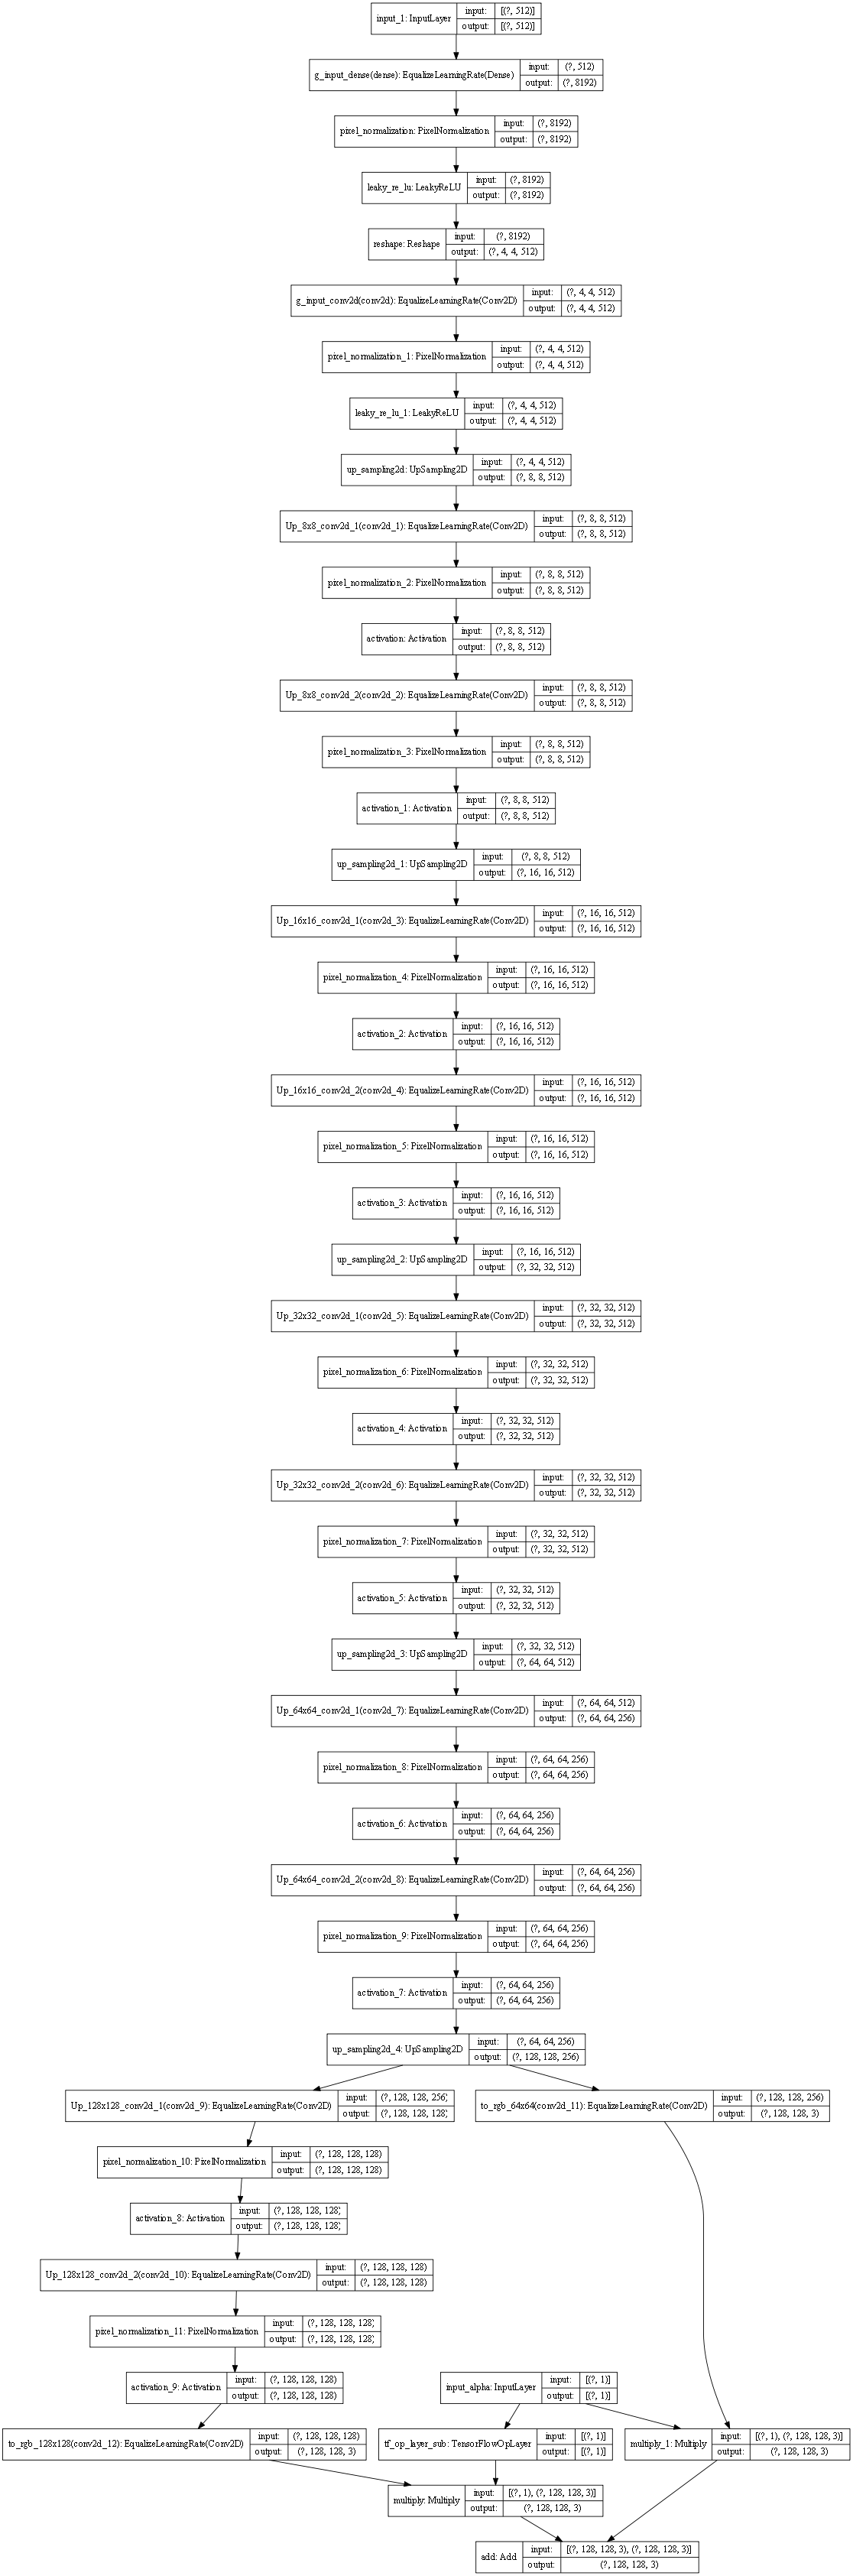

In [12]:
generator, discriminator = model_builder(image_size)
generator.summary()
plot_model(generator, show_shapes=True, dpi=64)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
from_rgb_128x128 (EqualizeLearn (None, 128, 128, 128 513         input_2[0][0]                    
__________________________________________________________________________________________________
Down_128x128_conv2d_1 (Equalize (None, 128, 128, 128 147585      from_rgb_128x128[0][0]           
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 128, 128, 128 0           Down_128x128_conv2d_1[0][0]      
____________________________________________________________________________________________

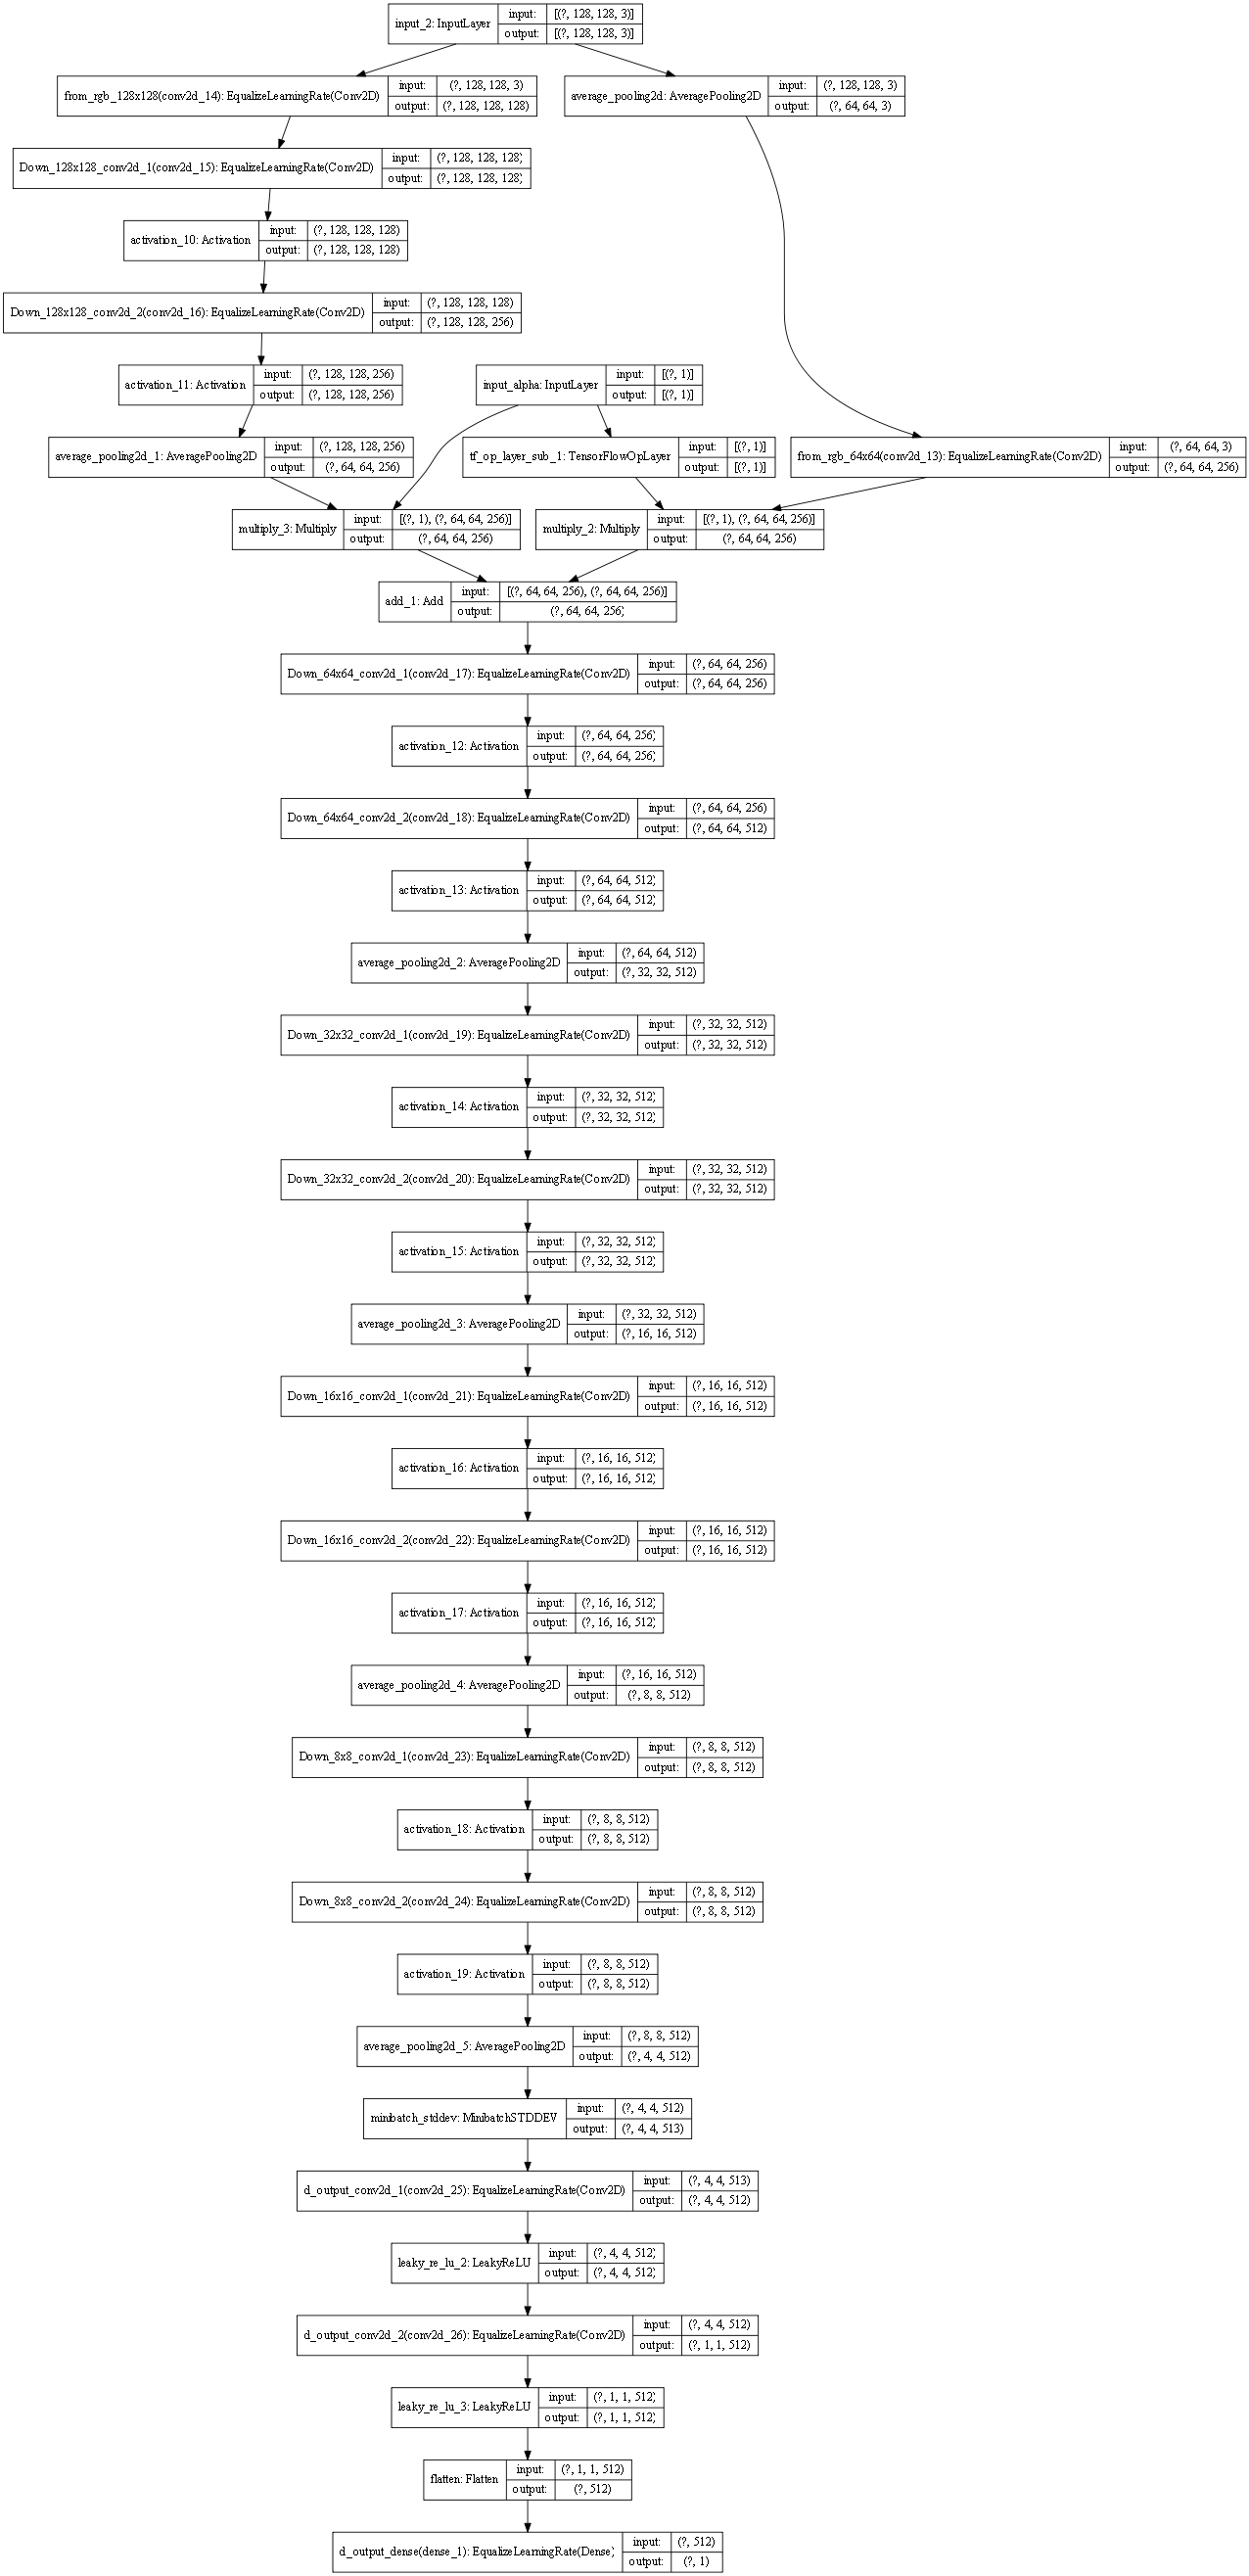

In [13]:
discriminator.summary()
plot_model(discriminator, show_shapes=True, dpi=64)

In [14]:
D_optimizer = Adam(learning_rate=LR, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON)
G_optimizer = Adam(learning_rate=LR, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON)

def learning_rate_decay(current_lr, decay_factor=DECAY_FACTOR):
    new_lr = max(current_lr / decay_factor, MIN_LR)
    return new_lr

def set_learning_rate(new_lr, D_optimizer, G_optimizer):
    '''
        Set new learning rate to optimizers
    '''
    K.set_value(D_optimizer.lr, new_lr)
    K.set_value(G_optimizer.lr, new_lr)
    
def calculate_batch_size(image_size):
    if image_size < 64:
        return 16
    elif image_size < 128:
        return 12
    elif image_size == 128:
        return 8
    elif image_size == 256:
        return 4
    else:
        return 3

In [15]:
def generate_and_save_images(model, epoch, test_input, figure_size=(12,6), subplot=(3,6), save=True, is_flatten=False):
    # Test input is a list include noise and label
    predictions = model.predict(test_input)
    fig = plt.figure(figsize=figure_size)
    for i in range(predictions.shape[0]):
        axs = plt.subplot(subplot[0], subplot[1], i+1)
        plt.imshow(predictions[i] * 0.5 + 0.5)
        plt.axis('off')
    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, '{}x{}_image_at_epoch_{:04d}.png'.format(predictions.shape[1], predictions.shape[2], epoch)))
    plt.show()

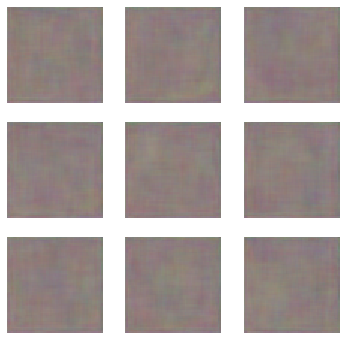

In [16]:
num_examples_to_generate = 9

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM], seed=0)
sample_alpha = np.repeat(1, num_examples_to_generate).reshape(num_examples_to_generate, 1).astype(np.float32)
generate_and_save_images(generator, 0, [sample_noise, sample_alpha], figure_size=(6,6), subplot=(3,3), save=False, is_flatten=False)

## Training steps

Adding tf function decorator in training functions can speed up training, but it cannot work with auto growing network. Which means you have to re-run the notebook, adjust the hyper parameters and set new current epoch to start with the higher resolution.

In [17]:
#@tf.function
def WGAN_GP_train_d_step(generator, discriminator, real_image, alpha, batch_size, step):
    '''
        One training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    noise = tf.random.normal([batch_size, NOISE_DIM])
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
    ###################################
    # Train D
    ###################################
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            fake_image = generator([noise, alpha], training=True)
            fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
            fake_mixed_pred = discriminator([fake_image_mixed, alpha], training=True)
            
        # Compute gradient penalty
        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
        
        fake_pred = discriminator([fake_image, alpha], training=True)
        real_pred = discriminator([real_image, alpha], training=True)
        
        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
    # Calculate the gradients for discriminator
    D_gradients = d_tape.gradient(D_loss,
                                            discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients,
                                                discriminator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)
            
#@tf.function
def WGAN_GP_train_g_step(generator, discriminator, alpha, batch_size, step):
    '''
        One training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    noise = tf.random.normal([batch_size, NOISE_DIM])
    ###################################
    # Train G
    ###################################
    with tf.GradientTape() as g_tape:
        fake_image = generator([noise, alpha], training=True)
        fake_pred = discriminator([fake_image, alpha], training=True)
        G_loss = -tf.reduce_mean(fake_pred)
    # Calculate the gradients for discriminator
    G_gradients = g_tape.gradient(G_loss,
                                            generator.trainable_variables)
    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients,
                                                generator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', G_loss, step=step)

In [18]:
math.ceil(total_data_number / batch_size)

1875

In [19]:
# Load previous resolution model
if image_size > 4:
    if os.path.isfile(os.path.join(MODEL_PATH, '{}x{}_generator.h5'.format(int(image_size / 2), int(image_size / 2)))):
        generator.load_weights(os.path.join(MODEL_PATH, '{}x{}_generator.h5'.format(int(image_size / 2), int(image_size / 2))), by_name=True)
        print("generator loaded")
    if os.path.isfile(os.path.join(MODEL_PATH, '{}x{}_discriminator.h5'.format(int(image_size / 2), int(image_size / 2)))):
        discriminator.load_weights(os.path.join(MODEL_PATH, '{}x{}_discriminator.h5'.format(int(image_size / 2), int(image_size / 2))), by_name=True)
        print("discriminator loaded")

generator loaded
discriminator loaded


In [20]:
# To resume training, comment it if not using.
if os.path.isfile(os.path.join(MODEL_PATH, '{}x{}_generator.h5'.format(int(image_size), int(image_size)))):
    generator.load_weights(os.path.join(MODEL_PATH, '{}x{}_generator.h5'.format(int(image_size), int(image_size))), by_name=False)
    print("generator loaded")
if os.path.isfile(os.path.join(MODEL_PATH, '{}x{}_discriminator.h5'.format(int(image_size), int(image_size)))):
    discriminator.load_weights(os.path.join(MODEL_PATH, '{}x{}_discriminator.h5'.format(int(image_size), int(image_size))), by_name=False)
    print("discriminator loaded")

generator loaded
discriminator loaded


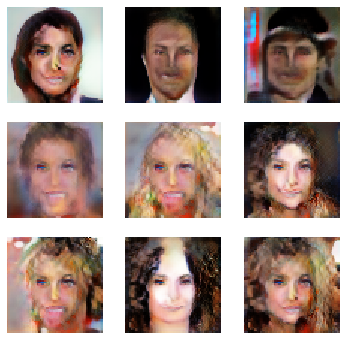

Saving model for epoch 240
Time taken for epoch 240 is 1934.5159633159637 sec

saving 128 * 128 model
creating 256 * 256 model
Making 256 * 256 dataset
start training 256 * 256 model
Start of epoch 241
Current alpha: 0.000000
Current resolution: 256 * 256


ValueError: in converted code:

    <ipython-input-17-daa0647e9afa>:17 WGAN_GP_train_d_step  *
        fake_mixed_pred = discriminator([fake_image_mixed, alpha], training=True)
    d:\users\henry\anaconda3\envs\cuda10\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py:847 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    <ipython-input-8-ac90c0e144d0>:34 call  *
        y = tf.reshape(inputs, [group_size, -1, s[1], s[2], s[3]])   # [GMHWC] Split minibatch into M groups of size G.
    d:\users\henry\anaconda3\envs\cuda10\lib\site-packages\tensorflow_core\python\ops\array_ops.py:131 reshape
        result = gen_array_ops.reshape(tensor, shape, name)
    d:\users\henry\anaconda3\envs\cuda10\lib\site-packages\tensorflow_core\python\ops\gen_array_ops.py:8117 reshape
        "Reshape", tensor=tensor, shape=shape, name=name)
    d:\users\henry\anaconda3\envs\cuda10\lib\site-packages\tensorflow_core\python\framework\op_def_library.py:793 _apply_op_helper
        op_def=op_def)
    d:\users\henry\anaconda3\envs\cuda10\lib\site-packages\tensorflow_core\python\framework\func_graph.py:548 create_op
        compute_device)
    d:\users\henry\anaconda3\envs\cuda10\lib\site-packages\tensorflow_core\python\framework\ops.py:3429 _create_op_internal
        op_def=op_def)
    d:\users\henry\anaconda3\envs\cuda10\lib\site-packages\tensorflow_core\python\framework\ops.py:1773 __init__
        control_input_ops)
    d:\users\henry\anaconda3\envs\cuda10\lib\site-packages\tensorflow_core\python\framework\ops.py:1613 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimension size must be evenly divisible by 32768 but is 49152 for 'model_3/minibatch_stddev_1/Reshape' (op: 'Reshape') with input shapes: [6,4,4,512], [5] and with input tensors computed as partial shapes: input[1] = [4,?,4,4,512].


In [21]:
current_learning_rate = LR
training_steps = math.ceil(total_data_number / batch_size)
# Fade in half of switch_res_every_n_epoch epoch, and stablize another half
alpha_increment = 1. / (switch_res_every_n_epoch / 2 * training_steps)
alpha = min(1., (CURRENT_EPOCH - 1) % switch_res_every_n_epoch * training_steps *  alpha_increment)

for epoch in range(CURRENT_EPOCH, EPOCHs + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    print('Current alpha: %f' % (alpha,))
    print('Current resolution: {} * {}'.format(image_size, image_size))
    # Using learning rate decay
#     current_learning_rate = learning_rate_decay(current_learning_rate)
#     print('current_learning_rate %f' % (current_learning_rate,))
#     set_learning_rate(current_learning_rate) 
    
    for step, (image) in enumerate(train_data):
        current_batch_size = image.shape[0]
        alpha_tensor = tf.constant(np.repeat(alpha, current_batch_size).reshape(current_batch_size, 1), dtype=tf.float32)
        # Train step
        
        WGAN_GP_train_d_step(generator, discriminator, image, alpha_tensor,
                             batch_size=tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
        WGAN_GP_train_g_step(generator, discriminator, alpha_tensor,
                             batch_size=tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
        
        
        # update alpha
        alpha = min(1., alpha + alpha_increment)
        
        if step % 10 == 0:
            print ('.', end='')
    
    # Clear jupyter notebook cell output
    clear_output(wait=True)
    # Using a consistent image (sample_X) so that the progress of the model is clearly visible.
    generate_and_save_images(generator, epoch, [sample_noise, sample_alpha], figure_size=(6,6), subplot=(3,3), save=True, is_flatten=False)
    
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        generator.save_weights(os.path.join(MODEL_PATH, '{}x{}_generator.h5'.format(image_size, image_size)))
        discriminator.save_weights(os.path.join(MODEL_PATH, '{}x{}_discriminator.h5'.format(image_size, image_size)))
        print ('Saving model for epoch {}'.format(epoch))
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))
    
    
    # Train next resolution
    if epoch % switch_res_every_n_epoch == 0:
        print('saving {} * {} model'.format(image_size, image_size))
        generator.save_weights(os.path.join(MODEL_PATH, '{}x{}_generator.h5'.format(image_size, image_size)))
        discriminator.save_weights(os.path.join(MODEL_PATH, '{}x{}_discriminator.h5'.format(image_size, image_size)))
        # Reset alpha
        alpha = 0
        previous_image_size = int(image_size)
        image_size = int(image_size * 2)
        if image_size > 512:
            print('Resolution reach 512x512, finish training')
            break
        print('creating {} * {} model'.format(image_size, image_size))
        generator, discriminator = model_builder(image_size)
        generator.load_weights(os.path.join(MODEL_PATH, '{}x{}_generator.h5'.format(previous_image_size, previous_image_size)), by_name=True)
        discriminator.load_weights(os.path.join(MODEL_PATH, '{}x{}_discriminator.h5'.format(previous_image_size, previous_image_size)), by_name=True)
        
        print('Making {} * {} dataset'.format(image_size, image_size))
        batch_size = calculate_batch_size(image_size)
        preprocess_function = partial(preprocess_image, target_size=image_size)
        train_data = list_ds.map(preprocess_function).shuffle(100).batch(batch_size)
        training_steps = math.ceil(total_data_number / batch_size)
        alpha_increment = 1. / (switch_res_every_n_epoch / 2 * training_steps)
        print('start training {} * {} model'.format(image_size, image_size))

## Test

In [25]:
generator, discriminator = model_builder(128)
generator.load_weights(os.path.join(MODEL_PATH, '{}x{}_generator.h5'.format(128, 128)))
discriminator.load_weights(os.path.join(MODEL_PATH, '{}x{}_discriminator.h5'.format(128, 128)))

In [38]:
test_noise = tf.random.normal([9, NOISE_DIM])
test_alpha = tf.ones([9, 1])
#generate_and_save_images(generator, 0, [test_noise], figure_size=(12,6), subplot=(3,6), save=False, is_flatten=False)

In [39]:
prediction = generator.predict([test_noise, test_alpha])

In [40]:
def image_grid(images, fig):
    """Return a 3x3 grid of the MNIST images as a matplotlib figure."""
    # Create a figure to contain the plot.
    for i in range(9):
        # Start next subplot.
        axs = fig.add_subplot(3, 3, i + 1)
        axs.set_xticks([])
        axs.set_yticks([])
        axs.imshow(np.clip(images[i] * 0.5 + 0.5, 0, 1))

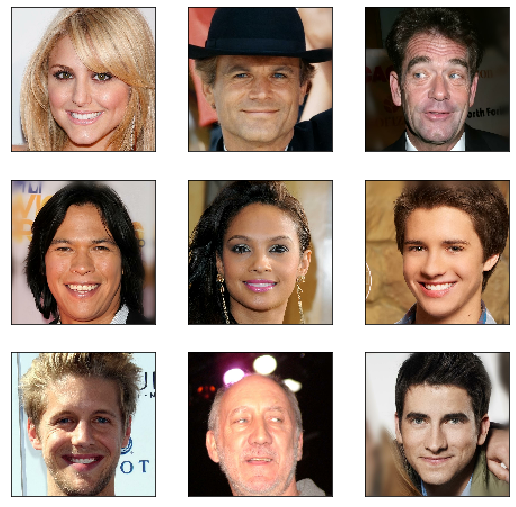

In [41]:
# Plot the real images
fig1 = plt.figure(figsize=(9,9))
image_grid(sample_img.numpy(), fig1)
plt.show()

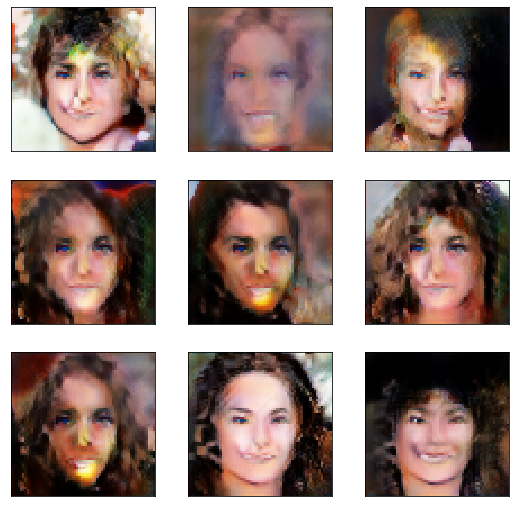

In [42]:
# Plot the fake images from the last epoch
fig2 = plt.figure(figsize=(9,9))
image_grid(prediction, fig2)